In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import pathlib
import random as rn
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
import tensorflow_hub as hub

from tensorflow.keras.callbacks import ReduceLROnPlateau



# Transfer Learning with InceptionV3

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import load_model
from sklearn.metrics import accuracy_score
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))


Num GPUs Available:  1


In [2]:
data_dir = "/Users/narendrafuloria/Downloads/Indian_Dataset/"
train_path = "/Users/narendrafuloria/Downloads/Indian_Dataset/Final_Training/Images"
test_path = "/Users/narendrafuloria/Downloads/Indian_Dataset/Final_Test/Images"
height = 100
width = 100

In [3]:
classes = { 0:'Give way',
            1:'No entry',
            2:'One-way traffic',
            3:'One-way traffic',
            4:'No vehcils in both directions',
            5:'NO ENTRY FOR CYCLES',
            6:'NO ENTRY FOR GOODS VEHCILS',
            7:'NO ENTRY FOR PEDESTRIANS',
            8:'NO ENTRY FOR BULLOCK CARTS',
            9:'NO ENTRY FOR HAND CARTS',
            10:'NO ENTRY FOR MOTOR VEHCILS',
            11:'HEIGHT LIMIT',
            12:'WEIGHT LIMIT',
            13:'AXLE WEIGHT LIMIT',
            14:'LENGTH LIMIT',
            15:'NO LEFT TURN',
            16:'NO RIGHT TURN',
            17:'NO OVERTAKING',
            18:'MAXIMUM SPEED LIMIT 90KM/HR',
            19:'MAXIMUM SPEED LIMIT 110 KM/HR',
            20:'HORN PROHIBITED',
            21:'NO PARKING',
            22:'NO STOPPING',
            23:'TURN LEFT',
            24:'TURN RIGHT',
            25:'STEEP DESCENT',
            26:'STEEP ASCENT',
            27:'NARROW ROAD',
            28: 'NARROW BRIDGE',
            29:'UNPROTECTED QUAY',
            30:'ROAD HUMP',
            31:'DIP',
            32:'LOOSE GRAVEL',
            33:'FALLING ROCKS',
            34:'CATTLE',
            35:'CROSSROADS',
            36:'SIDE ROAD JUNCTION',
            37:'SIDE ROAD JUNCTION',
            38:'OBLIQUE SIDE ROAD JUNCTION',
            40:'T- JUNCTION',
            41:'Y-JUNCTION',
            42:'STAGGERD SIDE ROAD JUNCTION',
            43:'STAGGERD SIDE ROAD JUNCTION',
            44: 'ROUNDABOUT',
            45: 'GUARDED LEVEL CROSSING AHEAD',
            46: 'UNGUARDED LEVEL CROSSING AHEAD',
            47: 'LEVEL CROSSING COUNTDOWN MARKER',
            48: 'LEVEL CROSSING COUNTDOWN MARKER',
            49: 'LEVEL CROSSING COUNTDOWN MARKER',
            50: 'LEVEL CROSSING COUNTDOWN MARKER',
            51: 'PARKING',
            52: 'BUS STOP',
            53: 'FIRST AID POST',
            54: 'TELEPHONE',
            55: 'FILLING STATION',
            56: 'HOTEL',
            57: 'RESTAURANT',
            58: 'REFRESHMENTS'}
            

In [4]:
batch_size = 90
seed = 42

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   validation_split=0.1)
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.1)
test_dataset = test_datagen.flow_from_directory(train_path,
                                                target_size=(height, width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')
print(len(train_dataset))

Found 11816 images belonging to 58 classes.
Found 1274 images belonging to 58 classes.
132


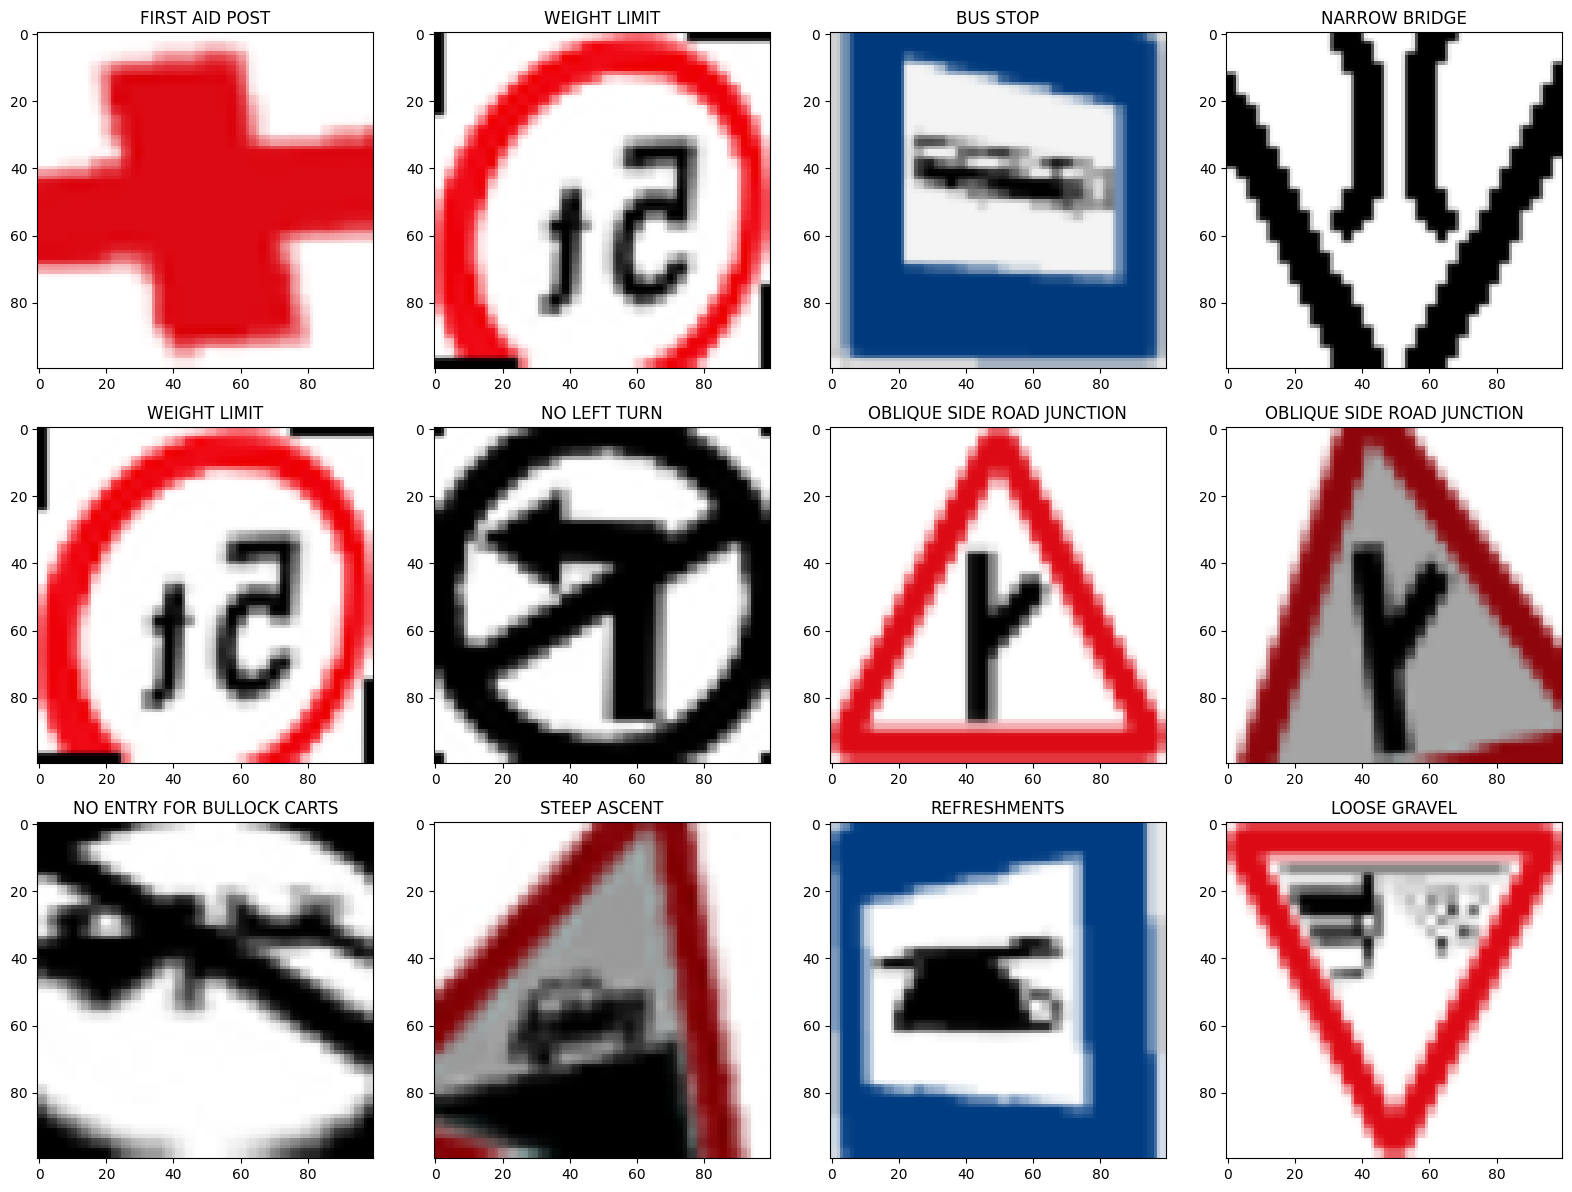

In [6]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
img,y = train_dataset.next()
for i in range(3):
    for j in range (4):
        l=rn.randint(0,batch_size-1)
        label = classes[int(list(train_dataset.class_indices.keys())[np.argmax(y[l])])]
        ax[i,j].imshow(img[l])
        ax[i,j].set_title(label)

plt.tight_layout()

In [7]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32 , kernel_size=(5,5), activation='relu', input_shape=(height,width,3)),
    keras.layers.Conv2D(filters= 64, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),


    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),



    keras.layers.Dropout(rate=0.5),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(58, activation='softmax')
])

2024-11-17 13:20:32.528465: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-17 13:20:32.528487: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-17 13:20:32.528494: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-17 13:20:32.528668: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-17 13:20:32.528683: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 64)        51264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 256)       2

In [9]:
alpha= 0.01
epochs=35
optim = keras.optimizers.legacy.Adam(learning_rate=alpha)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=3,         # Number of epochs with no improvement after which learning rate will be reduced
    min_delta=1e-2,      # Minimum change to qualify as an improvement
    cooldown=0,          # Number of epochs to wait before resuming normal operation after lr has been reduced
    min_lr=1e-6          # Lower bound on the learning rate
)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])


history = model.fit(train_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs=epochs,
                    validation_data=test_dataset,
                    validation_steps=len(test_dataset),callbacks = [reduce_lr])
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,2)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0,1)
fig.suptitle(f"Custom CNN Performance,  learning rate = {lr}")
plt.show() 

Epoch 1/35


2024-11-17 13:20:33.254042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 103s 772ms/step - loss: 3.7209 - accuracy: 0.2060 - val_loss: 40.5929 - val_accuracy: 0.0620 - lr: 0.0100
Epoch 2/35
132/132 [==============================] - 121s 919ms/step - loss: 1.9852 - accuracy: 0.4595 - val_loss: 11.5059 - val_accuracy: 0.1193 - lr: 0.0100
Epoch 3/35
132/132 [==============================] - 121s 917ms/step - loss: 1.2017 - accuracy: 0.6546 - val_loss: 2.2935 - val_accuracy: 0.5659 - lr: 0.0100
Epoch 4/35
132/132 [==============================] - 122s 926ms/step - loss: 0.8992 - accuracy: 0.7377 - val_loss: 1.0362 - val_accuracy: 0.6868 - lr: 0.0100
Epoch 5/35
132/132 [==============================] - 132s 1s/step - loss: 0.7193 - accuracy: 0.7805 - val_loss: 1.4605 - val_accuracy: 0.5824 - lr: 0.0100
Epoch 6/35
132/132 [==============================] - 264s 2s/step - loss: 0.6760 - accuracy: 0.7927 - val_loss: 0.6393 - val_accuracy: 0.7991 - lr: 0.0100
Epoch 7/35
132/132 [==============================] - 239s 2s

KeyboardInterrupt: 

In [10]:

# history = model.fit(train_dataset,
#                     steps_per_epoch=len(train_dataset),
#                     epochs=epochs,
#                     validation_data=test_dataset,
#                     validation_steps=len(test_dataset))
                

In [11]:
# fig,ax=plt.subplots(1,2)
# fig.set_size_inches(16,12)
# performance = pd.DataFrame(history.history)
# plt.figure(figsize=(10,7))
# ax[1].plot(performance[['loss','val_loss']])
# ax[1].legend(['Training Loss', 'Validation Loss'])
# ax[1].set_title('Model Loss')
# ax[1].set_xlabel('Epochs')
# ax[1].set_ylabel('Loss')
# ax[1].set_ylim(0,2)
# ax[0].plot(performance[['accuracy','val_accuracy']])
# ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
# ax[0].set_title('Model Accuracy')
# ax[0].set_xlabel('Epochs')
# ax[0].set_ylabel('Accuracy')
# ax[0].set_ylim(0.5,1)
# fig.suptitle('Custom CNN Performance')
# plt.show()

In [99]:
def map_pred(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]
# test_df = pd.read_csv('/Users/narendrafuloria/content/GTSRB/Final_Test/Images/GT-final_test.csv',delimiter=';')

destination_folder_2 = "/Users/narendrafuloria/Downloads/Indian_Dataset/Final_Test/Images/"
print(destination_folder_2 )
test_labels = np.array([])
imgs = np.array([])
for filename in os.listdir(destination_folder_2):
    if filename[0:2] != ".D":
        i = np.array(int(filename[0:2]))
        test_labels = np.append(test_labels , i)
        imgs = np.append(imgs,filename)
    
    else:
        print(os.path.join(destination_folder_2, filename))

   
# print(imgs)


data =[]

for img in imgs:
    try:
        image = cv2.imread(destination_folder_2 +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((height, width))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255
len(X_test)

/Users/narendrafuloria/Downloads/Indian_Dataset/Final_Test/Images/


820

In [100]:
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
print(len(pred))
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

26/26 [==============================] - 1s 13ms/step
820
Test Data accuracy:  68.04878048780488


4/4 [==============================] - 0s 27ms/step


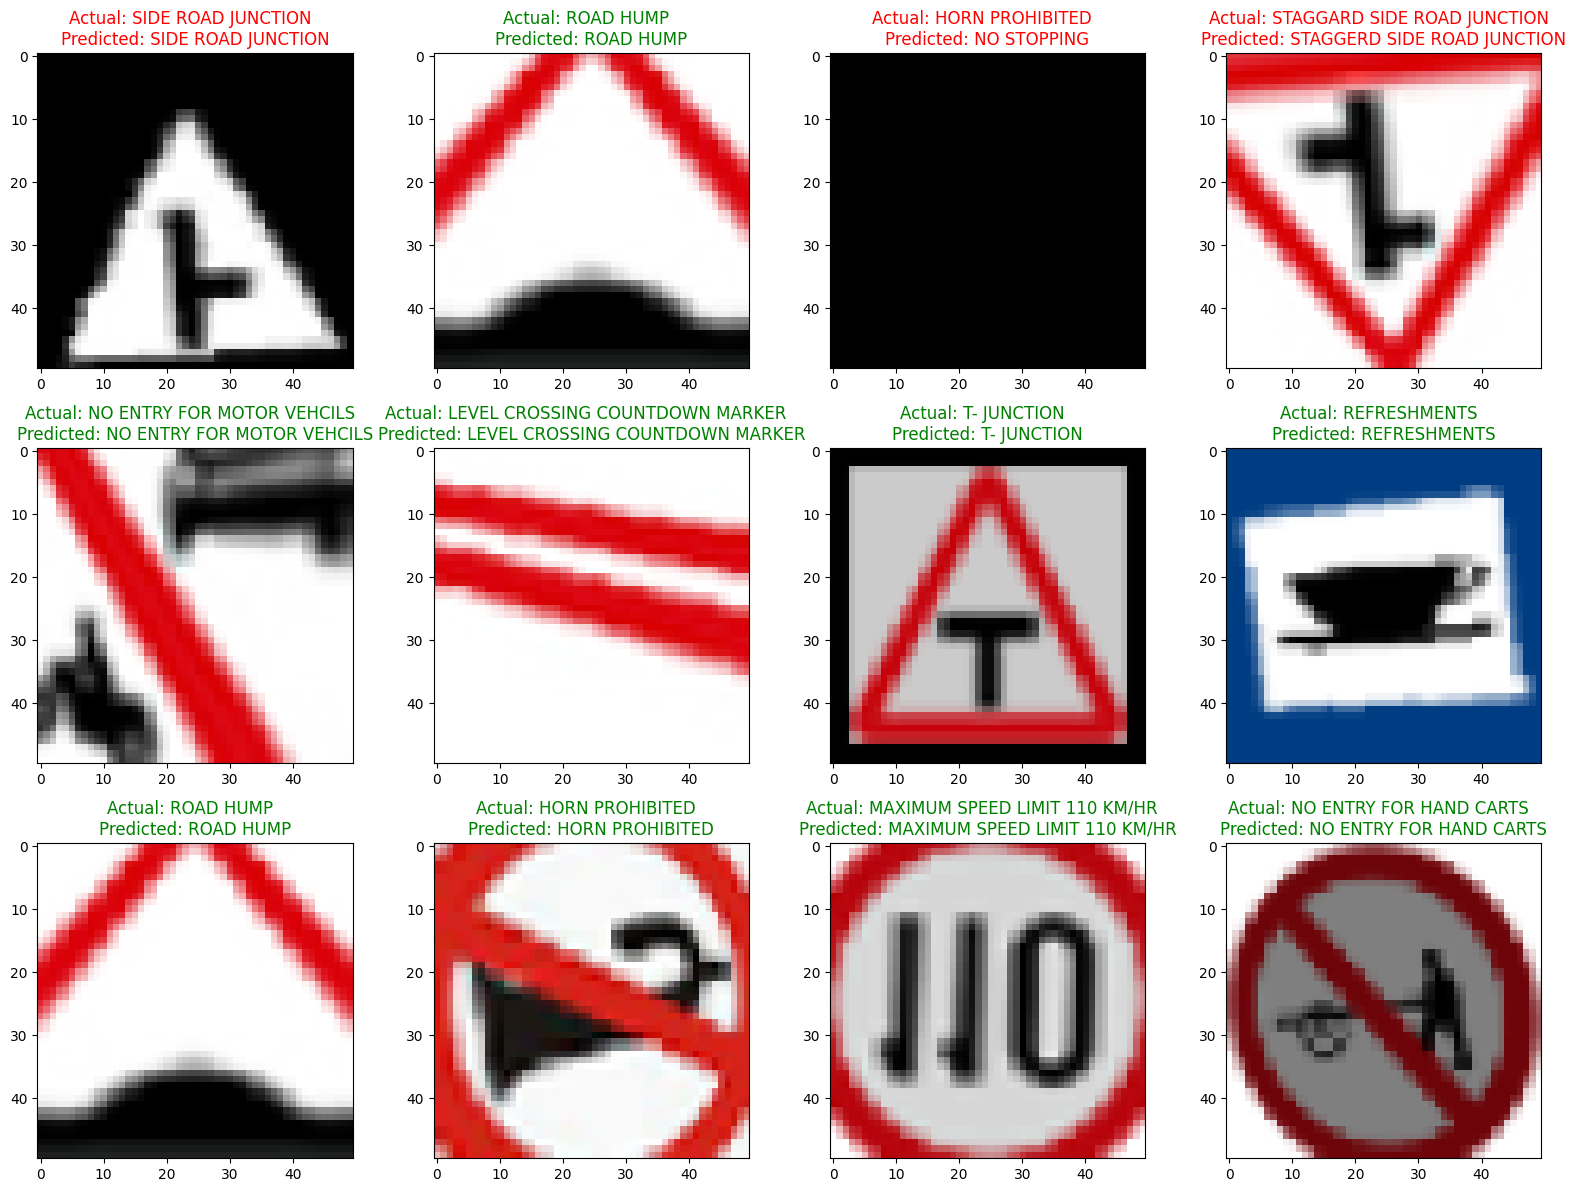

In [13]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_dataset.next()
predicted = model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))

for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()

# INCEPTION V3- BASED MODEL ARCHITECTURE

In [14]:

# Load InceptionV3 pre-trained on ImageNet
inception_height = 75
inception_width = 75
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(inception_height, inception_width, 3))
base_model.trainable = False

In [15]:
incept_model = tf.keras.Sequential([base_model,
                                   keras.layers.GlobalAveragePooling2D(),
                                   keras.layers.Dropout(0.5),
                                   keras.layers.Dense(256, activation='relu'),
                                   keras.layers.BatchNormalization(),
                                   keras.layers.Dropout(rate=0.3),
                                   keras.layers.Dense(58, activation='softmax')
                                ])
incept_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_99 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_3 (Dropout)         (None, 256)              

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(inception_height, inception_width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)
test_dataset = test_datagen.flow_from_directory(train_path,
                                                target_size=(inception_height, inception_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')
print(len(train_dataset))

Found 10595 images belonging to 58 classes.
Found 2619 images belonging to 58 classes.
106


In [17]:
alpha=0.001
epochs=15
optim = keras.optimizers.legacy.Adam(learning_rate=alpha)
incept_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [18]:
incept_history = incept_model.fit(train_dataset,
                            steps_per_epoch=len(train_dataset),
                            epochs=epochs,
                            validation_data=test_dataset,
                            validation_steps=len(test_dataset))

Epoch 1/15
106/106 [==============================] - 19s 160ms/step - loss: 2.4127 - accuracy: 0.4086 - val_loss: 1.4215 - val_accuracy: 0.6010
Epoch 2/15
106/106 [==============================] - 14s 132ms/step - loss: 1.4116 - accuracy: 0.6115 - val_loss: 1.1667 - val_accuracy: 0.6648
Epoch 3/15
106/106 [==============================] - 14s 131ms/step - loss: 1.1608 - accuracy: 0.6697 - val_loss: 1.0732 - val_accuracy: 0.6880
Epoch 4/15
106/106 [==============================] - 14s 131ms/step - loss: 1.0279 - accuracy: 0.7076 - val_loss: 0.9863 - val_accuracy: 0.7045
Epoch 5/15
106/106 [==============================] - 14s 131ms/step - loss: 0.9319 - accuracy: 0.7339 - val_loss: 0.9580 - val_accuracy: 0.7098
Epoch 6/15
106/106 [==============================] - 14s 131ms/step - loss: 0.8800 - accuracy: 0.7516 - val_loss: 0.9253 - val_accuracy: 0.7224
Epoch 7/15
106/106 [==============================] - 14s 134ms/step - loss: 0.8387 - accuracy: 0.7556 - val_loss: 0.8916 - val_ac

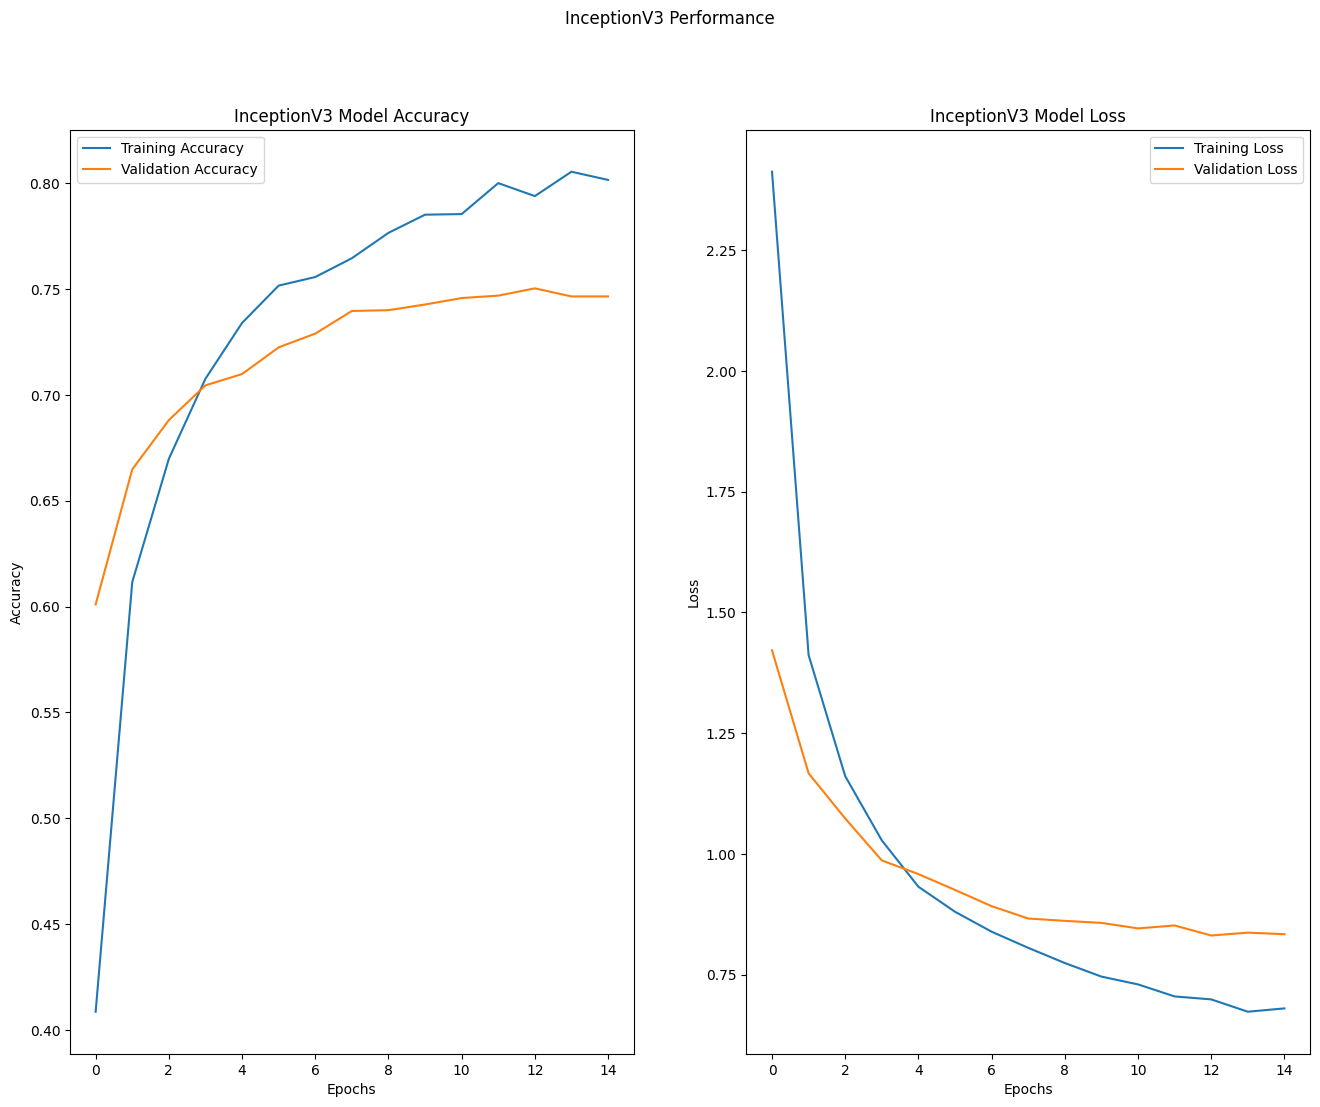

<Figure size 1000x700 with 0 Axes>

In [19]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(incept_history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('InceptionV3 Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
# ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('InceptionV3 Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
# ax[0].set_ylim(0.5,1)
fig.suptitle('InceptionV3 Performance')
plt.show()

# Saving the InceptionV3-Based Model


In [20]:
incept_model.save("InceptionV3.h5")


/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Mapping Predictions for InceptionV3 Model


In [21]:
def map_pred(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]
# test_df = pd.read_csv('/Users/narendrafuloria/content/GTSRB/Final_Test/Images/GT-final_test.csv',delimiter=';')

destination_folder_2 = "/Users/narendrafuloria/Downloads/Indian_Dataset/Final_Test/Images/"
print(destination_folder_2 )
test_labels = np.array([])
imgs = np.array([])
for filename in os.listdir(destination_folder_2):
    if filename[0:2] != ".D":
        i = np.array(int(filename[0:2]))
        test_labels = np.append(test_labels , i)
        imgs = np.append(imgs,filename)
    
    

   
# print(imgs)


data =[]

for img in imgs:
    try:
        image = cv2.imread(destination_folder_2 +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((height, width))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255
len(X_test)

/Users/narendrafuloria/Downloads/Indian_Dataset/Final_Test/Images/


801

In [22]:
def map_pred_inception(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]


data_inception = []
for img in imgs:
    try:
        image = cv2.imread(destination_folder_2 +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((inception_height, inception_width))
        data_inception.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test_incept = np.array(data_inception)
X_test_incept = X_test_incept/255

# Evaluating InceptionV3-Based Model on Test Data


In [23]:
from sklearn.metrics import accuracy_score
pred_incept = incept_model.predict(X_test_incept)
pred_incept = map_pred_inception(pred_incept.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred_incept)*100)

26/26 [==============================] - 4s 90ms/step
Test Data accuracy:  60.17478152309613


# MobileNetV2 as Base Model


In [24]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (height, width, 3), include_top = False, weights = "imagenet")
base_model.trainable = False

## MobileNetV2-Based Model Architecture


In [25]:
mob_model = tf.keras.Sequential([base_model,
                                   keras.layers.GlobalAveragePooling2D(),
                                   keras.layers.Dropout(0.2),
                                   keras.layers.Dense(512, activation='relu'),
                                   keras.layers.BatchNormalization(),
                                   keras.layers.Dropout(rate=0.2),
                                   keras.layers.Dense(58, activation='softmax')
                                ])
mob_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_100 (B  (None, 512)               2048      
 atchNormalization)                                              
                                                      

## Model Compilation for MobileNetV2-Based Model


In [26]:
alpha=0.01
epochs=8
optim = keras.optimizers.legacy.Adam(learning_rate=alpha)
mob_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Training MobileNetV2-Based Model


In [27]:

mob_history = mob_model.fit(train_dataset,
                          steps_per_epoch=len(train_dataset),
                          epochs=epochs,
                          validation_data=test_dataset,
                          validation_steps=len(test_dataset))

Epoch 1/8
106/106 [==============================] - 13s 108ms/step - loss: 1.5835 - accuracy: 0.5853 - val_loss: 1.3407 - val_accuracy: 0.6590
Epoch 2/8
106/106 [==============================] - 9s 81ms/step - loss: 0.9214 - accuracy: 0.7286 - val_loss: 1.0783 - val_accuracy: 0.7060
Epoch 3/8
106/106 [==============================] - 9s 80ms/step - loss: 0.7458 - accuracy: 0.7714 - val_loss: 0.9301 - val_accuracy: 0.7392
Epoch 4/8
106/106 [==============================] - 9s 84ms/step - loss: 0.6584 - accuracy: 0.7955 - val_loss: 0.8025 - val_accuracy: 0.7442
Epoch 5/8
106/106 [==============================] - 9s 89ms/step - loss: 0.5945 - accuracy: 0.8072 - val_loss: 0.7886 - val_accuracy: 0.7579
Epoch 6/8
106/106 [==============================] - 9s 88ms/step - loss: 0.5722 - accuracy: 0.8159 - val_loss: 0.8486 - val_accuracy: 0.7533
Epoch 7/8
106/106 [==============================] - 9s 87ms/step - loss: 0.5487 - accuracy: 0.8247 - val_loss: 0.7856 - val_accuracy: 0.7530
Epoc

## MobileNetV2-Based Model Performance Visualization


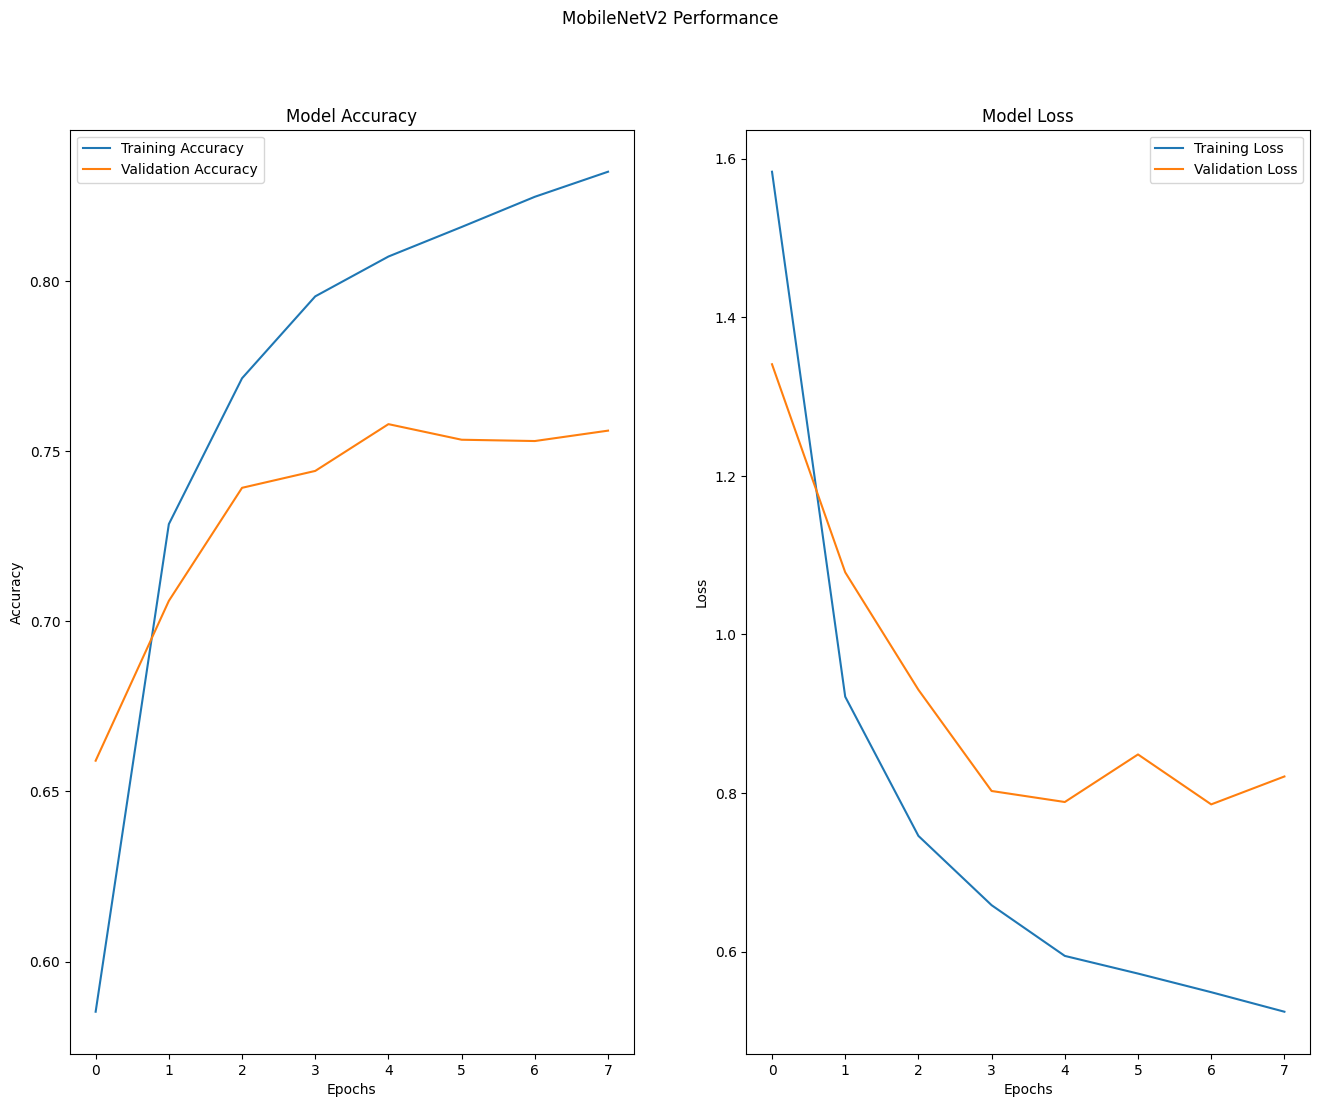

<Figure size 1000x700 with 0 Axes>

In [28]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(mob_history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
# ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
# ax[0].set_ylim(0.5,1)
fig.suptitle('MobileNetV2 Performance')
plt.show()

## MobileNetV2-Based Model Evaluation on Test Data


In [29]:
from sklearn.metrics import accuracy_score
pred = mob_model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

26/26 [==============================] - 3s 60ms/step
Test Data accuracy:  13.108614232209737


# VGG19-Based Model Architecture


In [30]:
vgg_model = tf.keras.Sequential([VGG19(weights='imagenet', include_top=False, input_shape=(height,width,3)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(512, activation='sigmoid'),
                                 keras.layers.Dense(58, activation='softmax')
                                ])

vgg_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization_101 (B  (None, 1, 1, 512)         2048      
 atchNormalization)                                              
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               262656    
                                                                 
 dense_9 (Dense)             (None, 58)                29754     
                                                                 
Total params: 20318842 (77.51 MB)
Trainable params: 20317818 (77.51 MB)
Non-trainable params: 1024 (4.00 KB)
___________

In [31]:
from tensorflow.keras.models import Model

# Create a new model that will return the outputs of the intermediate layers
layer_outputs = [layer.output for layer in vgg_model.layers]
print(layer_outputs)
intermediate_model = Model(inputs=vgg_model.input, outputs=layer_outputs)

# Get a sample input (ensure it matches your input shape)
sample_input = np.random.random((1, height, width, 3))  # Adjust dimensions accordingly

# Get the outputs for this sample input
intermediate_outputs = intermediate_model.predict(sample_input)

# Print shapes of outputs from each layer
for i, output in enumerate(intermediate_outputs):
    print(f"Layer {i} ({model.layers[i].name}) output shape: {output.shape}")

[<KerasTensor: shape=(None, 1, 1, 512) dtype=float32 (created by layer 'block5_pool')>, <KerasTensor: shape=(None, 1, 1, 512) dtype=float32 (created by layer 'batch_normalization_101')>, <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'flatten_2')>, <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'dense_8')>, <KerasTensor: shape=(None, 58) dtype=float32 (created by layer 'dense_9')>]


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'") at layer "block1_conv1". The following previous layers were accessed without issue: []

In [53]:
from tensorflow.keras.layers import Input

input_1 = Input(shape=(height, width, 3))
input_2 = Input(shape=(height, width, 3))

In [54]:
from tensorflow.keras.layers import Concatenate
concatenated = Concatenate()([input_1, input_2])



In [56]:
vgg_model.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization_102 (B  (None, 1, 1, 512)         2048      
 atchNormalization)                                              
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 58)                29754     
                                                                 
Total params: 20318842 (77.51 MB)
Trainable params: 20317818 (77.51 MB)
Non-trainable params: 1024 (4.00 KB)
___________

In [57]:
for layer in vgg_model.layers:
    print(layer.name, layer.output_shape)

vgg19 (None, 1, 1, 512)
batch_normalization_102 (None, 1, 1, 512)
flatten_3 (None, 512)
dense_10 (None, 512)
dense_11 (None, 58)


In [38]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Model Compilation for VGG19-Based Model


In [58]:
alpha=0.0001
epochs=8
optim = keras.optimizers.legacy.Adam(learning_rate=alpha)
vgg_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Training VGG19-Based Model


In [59]:
print(train_dataset)
vgg_history = vgg_model.fit(train_dataset,
                        steps_per_epoch=len(train_dataset),
                        epochs=epochs,
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset))

Epoch 1/8


2024-11-16 10:59:51.452566: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14098398785026951895
2024-11-16 10:59:51.452601: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18028991715228114417


InvalidArgumentError: Graph execution error:

Detected at node sequential_5/dense_10/BiasAdd defined at (most recent call last):
  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/runpy.py", line 87, in _run_code

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 728, in start

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/var/folders/20/hwsvjxys13vdjtgrj5x3dxrc0000gn/T/ipykernel_39546/196623613.py", line 2, in <module>

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/layers/core/dense.py", line 252, in call

Detected at node sequential_5/dense_10/BiasAdd defined at (most recent call last):
  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/runpy.py", line 87, in _run_code

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 728, in start

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/var/folders/20/hwsvjxys13vdjtgrj5x3dxrc0000gn/T/ipykernel_39546/196623613.py", line 2, in <module>

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/narendrafuloria/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/layers/core/dense.py", line 252, in call

2 root error(s) found.
  (0) INVALID_ARGUMENT:  In[0] mismatch In[1] shape: 2048 vs. 512: [100,2048] [512,512] 0 0
	 [[{{node sequential_5/dense_10/BiasAdd}}]]
	 [[sequential_5/dense_11/Softmax/_20]]
  (1) INVALID_ARGUMENT:  In[0] mismatch In[1] shape: 2048 vs. 512: [100,2048] [512,512] 0 0
	 [[{{node sequential_5/dense_10/BiasAdd}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_100523]

## VGG19-Based Model Performance Visualization


In [ ]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(vgg_history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.5,1)
fig.suptitle('VGG19 Performance')
plt.show()

## VGG19-Based Model Evaluation on Test Data


In [ ]:

from sklearn.metrics import accuracy_score
pred = vgg_model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

## Saving the VGG19-Based Model

In [ ]:
vgg_model.save("VGG.h5")


## Visualizing VGG19 Model Predictions on Validation Data

In [ ]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_dataset.next()
predicted = vgg_model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))
for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()